# CS498 MP1 Autonomous Vehicle Safety Analysis

### Zhonghao Zhao (zz7),   Yimeng Han (Yimengh2), Zining Chen (ziningc2)


In [277]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt 
from scipy import stats as st
from math import sqrt
import sklearn
import calendar
import pandas_profiling

## Task 0 – Getting to know the analysis environment
### 1. Import Dataset

In [276]:
av_disengagement = pd.read_csv("mp1/mp1_av_disengagements.csv")
av_totalmiles = pd.read_csv("mp1/mp1_av_totalmiles.csv")

In [180]:
av_totalmiles.head()
#pandas_profiling.ProfileReport(av_disengagement)

Month                Car  miles driven in autonomous mode  \
0  14-Sep  WDD2221851A001072                             4207   
1  14-Oct  WDD2221851A001072                            23971   
2  14-Nov  WDD2221851A001072                            15837   
3  14-Dec  WDD2221851A001072                             9413   
4  15-Jan  WDD2221851A001072                            18192   

   total number of disengagements  number of automatic disengagements  \
0                              44                                  24   
1                             228                                 100   
2                             141                                  66   
3                              36                                  15   
4                              48                                  18   

   number of manual disengagements  
0                               20  
1                              128  
2                               75  
3                               21  
4                               30

In [179]:
av_disengagement.head()
#pandas_profiling.ProfileReport(av_totalmiles)

Month                Car      Location Weather TypeOfTrigger  \
0  14-Sep  WDD2221851A001072  urban-street  cloudy     automatic   
1  14-Sep  WDD2221851A001072  urban-street  cloudy     automatic   
2  14-Sep  WDD2221851A001072  urban-street  cloudy     automatic   
3  14-Sep  WDD2221851A001072  urban-street  cloudy     automatic   
4  14-Sep  WDD2221851A001072  urban-street  cloudy     automatic   

   ReactionTime                              Cause  
0          0.58  Incorrect Traffic Light Detection  
1          0.66    Adverse road surface conditions  
2          1.93        Position Estimation Failure  
3          0.65                  Emergency Vehicle  
4          0.64    Adverse road surface conditions

### 2. Summarize Information about Data

#### Total number of AV disengagements over the entire duration of available data

In [19]:
len(av_disengagement)

1024

#### Number of unique months that have recorded AV disengagements

In [181]:
len(av_disengagement['Month'].unique())

15

#### List of unique locations of AV disengagements

In [182]:
list(av_disengagement['Location'].unique())

['urban-street', 'highway']

#### Number of unique causes for AV disengagements

In [183]:
len(av_disengagement['Cause'].unique())

10

#### Which columns in the datasets (if any) have missing values? How many missing values do these column(s) have? 

In [186]:
av_disengagement.isnull().sum()

Month              0
Car                0
Location           0
Weather            0
TypeOfTrigger      0
ReactionTime     532
Cause              0
dtype: int64

ReactionTime has missing values, it has 532 missing values

###  3. Plot a pie chart for the causes of AV disengagement. Based on the pie-chart, list the top 2 leading causes of disengagement?

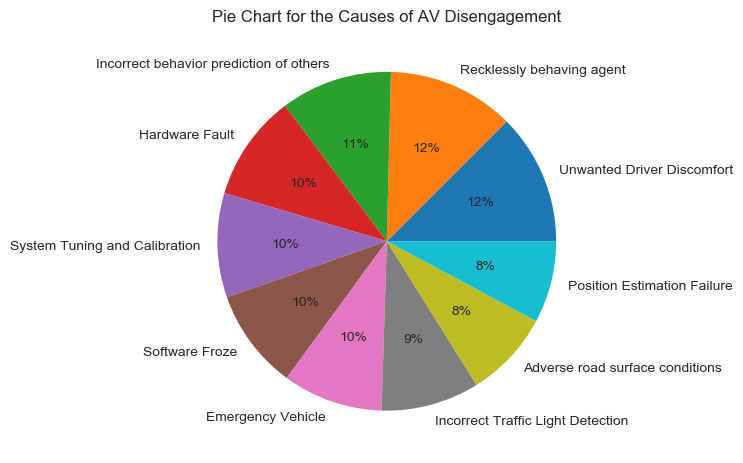

In [190]:
causes = av_disengagement['Cause'].value_counts()
patches, texts, _ = plt.pie(causes, 
        # grab labels from frame keys
        labels=causes.keys(),
        # some formatting
        autopct='%.0f%%')
plt.title("Pie Chart for the Causes of AV Disengagement")
plt.show()

**Based on the pie chart, Unwanted Driver Discomfort and Recklessly behaving agent is the top 2 Causes of disengagements.**

### 4. Visualize the trend of disengagement/mile over time with monthly granularity. How would you describe the trend? Are AV’s maturing over time?

In [278]:
months = list(calendar.month_abbr)[1:]
origin_month = av_totalmiles["Month"]
Convert_Dic = {months[index]:("0"+str(index+1)) if index <= 8 else str(index+1) for index in range(12)}
new_months = ["20"+cur_month[:3]+Convert_Dic[cur_month[-3:]] for cur_month in origin_month]
av_totalmiles["Month"] = new_months

Text(0.5, 1.0, 'Miles Driven in Autonomous Mode over Time')

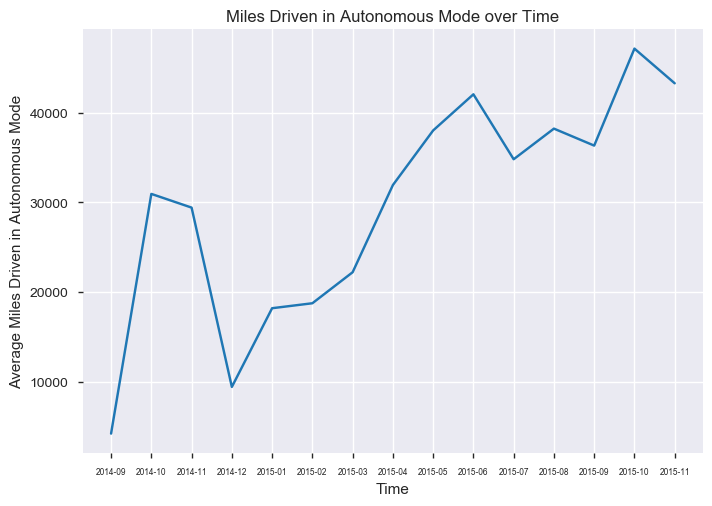

In [282]:
miles_time = av_totalmiles["miles driven in autonomous mode"].groupby(av_totalmiles.Month).mean()
plt.plot(miles_time)
plt.tick_params(axis='x', which='major', labelsize=6)
plt.xlabel("Time")
plt.ylabel("Average Miles Driven in Autonomous Mode")
plt.title("Miles Driven in Autonomous Mode over Time")

Text(0.5, 1.0, 'Disengagement Number over Time')

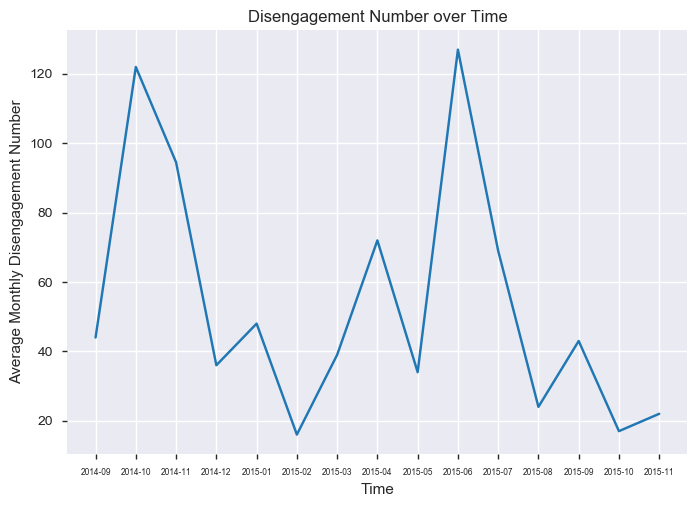

In [281]:
Disengagement_time = av_totalmiles["total number of disengagements"].groupby(av_totalmiles.Month).mean()
plt.plot(Disengagement_time)
plt.tick_params(axis='x', which='major', labelsize=6)
plt.xlabel("Time")
plt.ylabel("Average Monthly Disengagement Number")
plt.title("Disengagement Number over Time")

**From the two graphs, we can see that people are more willing to drive in AV mode as time goes by. Also, despite a big increase in monthly disengagement number of AV mode during May 2015 to July 2015, the number of disengagement is in a decreasing trend.**

## Task 1 – Basic Analysis of AV Disengagements

### 1. What do the following distributions signify about samples drawn from it

#### Gaussian Distribution

Gaussian – continuous function which approximates the exact binomial distribution of events. It signifies the mean and standard deviation of the sample.

#### Exponential Distribution

Exponential – Memoryless; Related to poisson distribution

#### Weibull Distribution

Weibull distribution takes two parameters 𝜆 and 𝑘. 𝜆 defines scale and 𝑘 defines shape.
Based on the value of k, we can get information about the shape of failure rate over time.


### 2. Plot the probability distribution of reaction times. Does this distribution fit any known distributions (Gaussian, Weibull, Exponential)? What does the fit distribution signify?

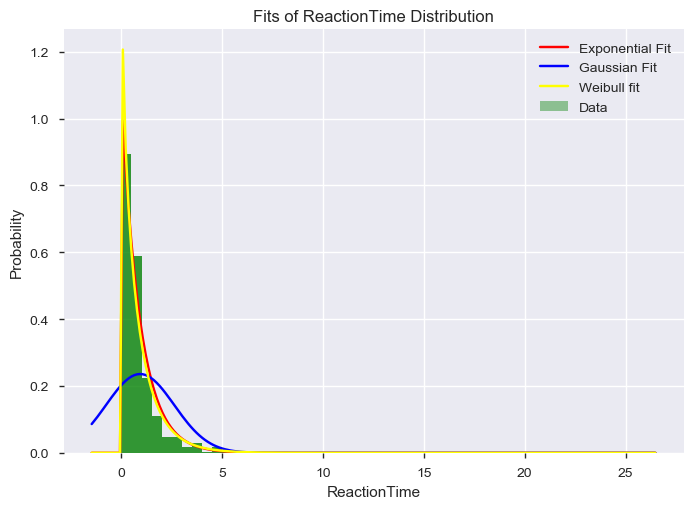

In [293]:
sns.distplot(av_disengagement['ReactionTime'].dropna(), fit_kws={"color":"red"},kde=False, fit=st.expon,color = "g")#,bins=10)
sns.distplot(av_disengagement['ReactionTime'].dropna(), fit_kws={"color":"blue"},kde=False, fit=st.norm,color = "g")#,bins=10)
sns.distplot(av_disengagement['ReactionTime'].dropna(), fit_kws={"color":"yellow"},kde=False, fit=st.weibull_min,color = "g")#,bins=10)
plt.legend(['Exponential Fit','Gaussian Fit','Weibull fit', 'Data'])
plt.title("Fits of ReactionTime Distribution")
plt.ylabel("Probability")
plt.show()

**Weibull and Exponential Distribution both seem to be good fit. It signifies the fact that the probability of a number of reactionTime decreases dramatically as reaction time increases**

### 3. Compute the average reaction time

In [198]:
av_disengagement['ReactionTime'].dropna().mean()

0.9297703252032526

In [202]:
av_disengagement.ReactionTime.groupby(av_disengagement.Location).mean()

Location
highway         1.48000
urban-street    0.92865
Name: ReactionTime, dtype: float64

### 4. Is the mean reaction time for humans in AV cars different from non-AV cars? Perform a hypothesis testing at a 0.05 significance level.

$H_0$: Mean_ReactionTime_AV = Mean_ReactionTime_non-AV    $H_1$: Mean_ReactionTime_AV $\neq$ Mean_ReactionTime_non-AV,   

In [204]:
mean = av_disengagement['ReactionTime'].dropna().mean()
sd = av_disengagement['ReactionTime'].dropna().std()
se = sd / sqrt(len(av_disengagement['ReactionTime'].dropna()))

In [205]:
mean,se

(0.9297703252032526, 0.07635061071241418)

In [208]:
Z_Score = (mean - 1.09) / se
Z_Score

-2.0986037086235774

In [209]:
p_value = 2*st.norm.cdf(Z_Score)
p_value

0.035851849171929545

**Since p value < 0.05, at the significance level at 0.05, we rejected the null hypothesis, the mean reaction time for humans in AV cars different from non-AV cars.**

### 5. Plot the probability distribution of disengagements/mile with monthly granularity. Does this distribution fit any known distributions (Gaussian, Weibull, Exponential)? What does the distribution that fits signify?

#### Miles Distribution

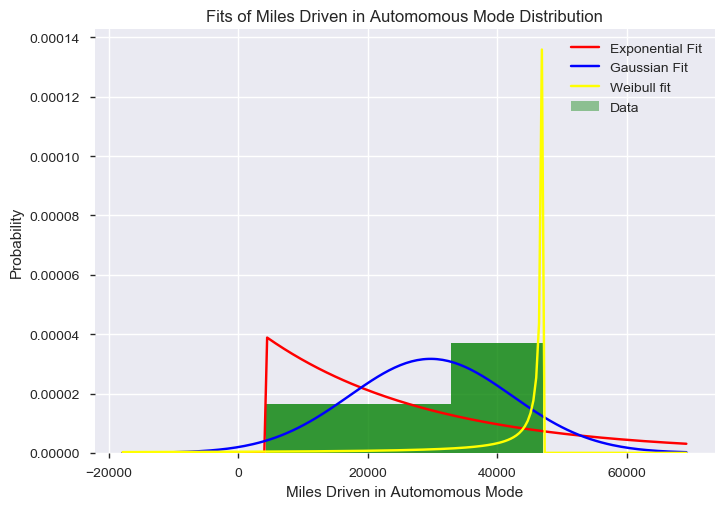

In [297]:
sns.distplot(av_totalmiles['miles driven in autonomous mode'].dropna(), fit_kws={"color":"red"},kde=False, fit=st.expon,color = "g")#,bins=10)
sns.distplot(av_totalmiles['miles driven in autonomous mode'].dropna(), fit_kws={"color":"blue"},kde=False, fit=st.norm,color = "g")#,bins=10)
sns.distplot(av_totalmiles['miles driven in autonomous mode'].dropna(), fit_kws={"color":"yellow"},kde=False, fit=st.weibull_max,color = "g")#,bins=10)
plt.legend(['Exponential Fit','Gaussian Fit','Weibull fit', 'Data'])
plt.title("Fits of Miles Driven in Automomous Mode Distribution")
plt.ylabel("Probability")
plt.xlabel("Miles Driven in Automomous Mode")
plt.show()

**The Miles Distribution seems to not fit any distribution from Gaussian, Exponential, and Weibull.**

#### Disengagement Distribution

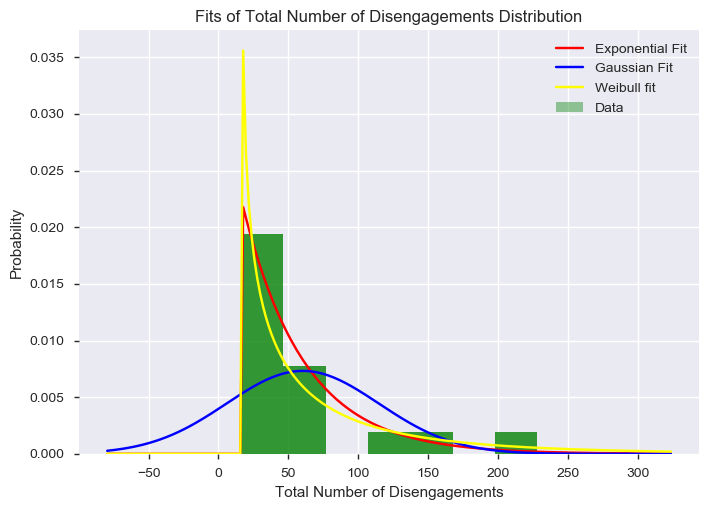

In [299]:
sns.distplot(av_totalmiles['total number of disengagements'].dropna(), fit_kws={"color":"red"},kde=False, fit=st.expon,color = "g")#,bins=10)
sns.distplot(av_totalmiles['total number of disengagements'].dropna(), fit_kws={"color":"blue"},kde=False, fit=st.norm,color = "g")#,bins=10)
sns.distplot(av_totalmiles['total number of disengagements'].dropna(), fit_kws={"color":"yellow"},kde=False, fit=st.weibull_min,color = "g")#,bins=10)
plt.legend(['Exponential Fit','Gaussian Fit','Weibull fit', 'Data'])
plt.title("Fits of Total Number of Disengagements Distribution")
plt.ylabel("Probability")
plt.xlabel("Total Number of Disengagements")
plt.show()

**Weibull and Exponential Distribution both seem to be good fits for Disengagements Distribution. It signifies the fact that the probability decreases as the total number of Disengagements increases**